In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import shap

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


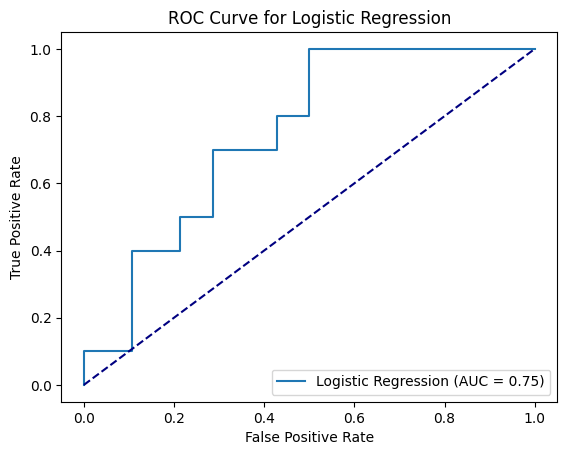

ROC AUC Score: 0.75
Accuracy: 0.68
Confusion Matrix:
[[25  3]
 [ 9  1]]


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Load the data
data = pd.read_excel('/content/drive/MyDrive/fall 24/cdss discovery - ucsf covid/Key data files/delirium cohort demographics.xlsx', nrows=129)

# Step 2: Data Preprocessing
# Handle missing values
for column in data.select_dtypes(include=['float64', 'int64']).columns:
    data[column] = data[column].fillna(data[column].mean())

# Remove rows with 'Unknown' values in specific columns
data = data.loc[(data['Race'] != 'Unknown') & (data['Hispanic ethnicity'] != 'Unknown') & (data['Dementia'] != 'Unknown')]

# Step 3: Set up OneHotEncoder for categorical variables
def ohe_col(data, column):
    """
    One-hot-encodes roof material. New columns are of the form "Roof Material_MATERIAL".
    """
    ohenc = OneHotEncoder()
    ohenc.fit(data[[column]])
    coldata = ohenc.transform(data[[column]]).toarray()
    coldf = pd.DataFrame(data=coldata, columns=ohenc.get_feature_names_out(), index=data.index)
    return data.join(coldf)

data = ohe_col(data, "Race")
data = ohe_col(data, "Sex at Birth")
data = ohe_col(data, "Dementia")

# Step 4: Split the data
# Define features and target (ensure 'Dementia' is not a feature if it’s the target)
features = ['Age at Admission', 'SOFA', 'WHO Scale']  + list(data.filter(regex='^Race_').columns)  + list(data.filter(regex='^Sex at Birth_').columns) + list(data.filter(regex='^Dementia_').columns)
X = data[features]
y = data['Delirium at any time during hospitalization']  # Delirium status (0 = no, 1 = yes)

# Step 3: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 5: Model Training (Logistic Regression)
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

# Step 6: Make Predictions and Evaluate the Model
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Get probability scores
y_pred = model.predict(X_test)  # Get binary predictions

# Calculate AUC-ROC score
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Step 7: Plot the ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure()
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')  # Reference line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression')
plt.legend(loc='lower right')
plt.show()

# Step 8: Output additional metrics
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f'ROC AUC Score: {roc_auc:.2f}')
print(f'Accuracy: {accuracy:.2f}')
print('Confusion Matrix:')
print(conf_matrix)

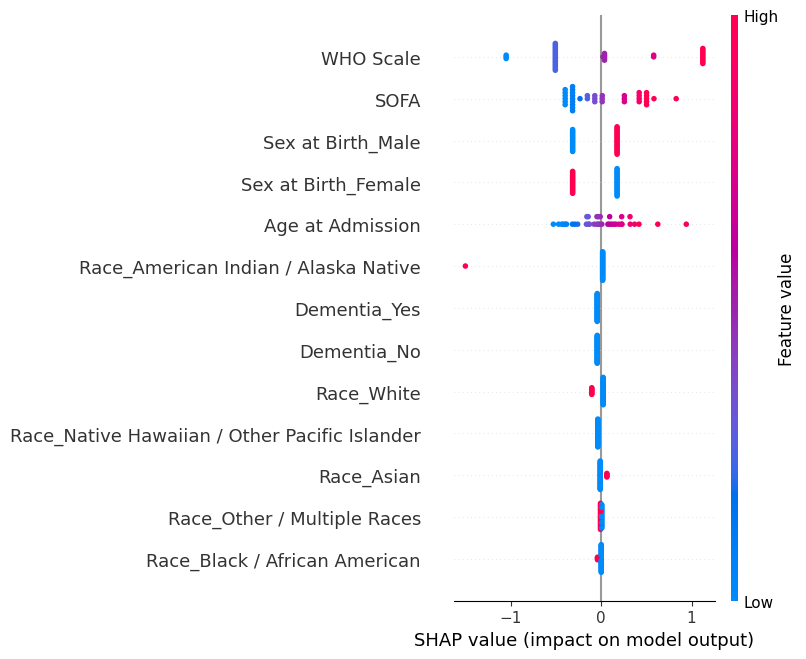

In [ ]:
import shap
from sklearn.preprocessing import StandardScaler

# Step 9: Standardize the numerical features for SHAP (Optional, depending on the logistic regression convergence)
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

# Step 10: Fit model on scaled data (replace original model with one trained on scaled data)
model.fit(X_train_scaled, y_train)

# Step 11: Initialize SHAP explainer and calculate SHAP values for the test set
explainer = shap.Explainer(model, X_train_scaled)
shap_values = explainer(X_test_scaled)

# Step 12: Plot SHAP Summary Plot
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test_scaled, plot_type="dot", show=True)

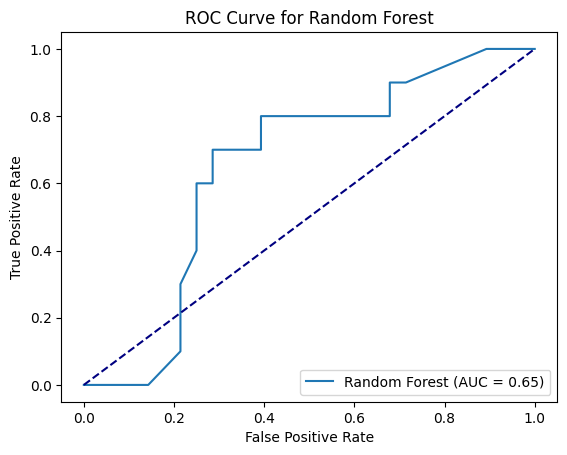

ROC AUC Score: 0.65
Accuracy: 0.63
Confusion Matrix:
[[22  6]
 [ 8  2]]


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Load the data
data = pd.read_excel('/content/drive/MyDrive/fall 24/cdss discovery - ucsf covid/Key data files/delirium cohort demographics.xlsx', nrows=129)

# Step 2: Data Preprocessing
# Handle missing values
for column in data.select_dtypes(include=['float64', 'int64']).columns:
    data[column] = data[column].fillna(data[column].mean())

# Remove rows with 'Unknown' values in specific columns
data = data.loc[(data['Race'] != 'Unknown') & (data['Hispanic ethnicity'] != 'Unknown') & (data['Dementia'] != 'Unknown')]

# Step 3: One-Hot Encode Categorical Variables
def ohe_col(data, column):
    ohenc = OneHotEncoder()
    ohenc.fit(data[[column]])
    coldata = ohenc.transform(data[[column]]).toarray()
    coldf = pd.DataFrame(data=coldata, columns=ohenc.get_feature_names_out(), index=data.index)
    return data.join(coldf)

data = ohe_col(data, "Race")
data = ohe_col(data, "Sex at Birth")
data = ohe_col(data, "Dementia")

# Step 4: Train-Test Split
features = ['Age at Admission', 'SOFA', 'WHO Scale'] + list(data.filter(regex='^Race_').columns) + list(data.filter(regex='^Sex at Birth_').columns) + list(data.filter(regex='^Dementia_').columns)
X = data[features]
y = data['Delirium at any time during hospitalization']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize Numerical Features
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

# Step 5: Train Random Forest Model
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)

# Step 6: Make Predictions and Evaluate Model
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]
y_pred = rf_model.predict(X_test)

# Calculate AUC-ROC score
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Step 7: Plot the ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')  # Reference line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest')
plt.legend(loc='lower right')
plt.show()

# Step 8: Output Additional Metrics
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f'ROC AUC Score: {roc_auc:.2f}')
print(f'Accuracy: {accuracy:.2f}')
print('Confusion Matrix:')
print(conf_matrix)

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 20, number of negative: 66
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000989 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 53
[LightGBM] [Info] Number of data points in the train set: 86, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.232558 -> initscore=-1.193922
[LightGBM] [Info] Start training from score -1.193922
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

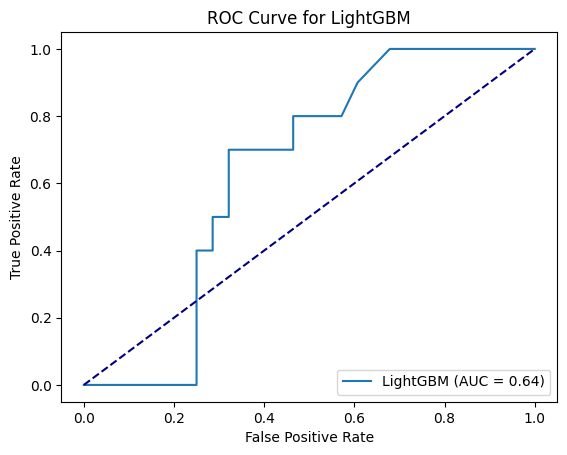

ROC AUC Score: 0.64
Accuracy: 0.55
Confusion Matrix:
[[21  7]
 [10  0]]


In [ ]:
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Load the data
data = pd.read_excel('/content/drive/MyDrive/fall 24/cdss discovery - ucsf covid/Key data files/delirium cohort demographics.xlsx', nrows=129)

# Step 2: Data Preprocessing
# Handle missing values
for column in data.select_dtypes(include=['float64', 'int64']).columns:
    data[column] = data[column].fillna(data[column].mean())

# Remove rows with 'Unknown' values in specific columns
data = data.loc[(data['Race'] != 'Unknown') & (data['Hispanic ethnicity'] != 'Unknown') & (data['Dementia'] != 'Unknown')]

# Step 3: One-Hot Encode Categorical Variables
def ohe_col(data, column):
    ohenc = OneHotEncoder()
    ohenc.fit(data[[column]])
    coldata = ohenc.transform(data[[column]]).toarray()
    coldf = pd.DataFrame(data=coldata, columns=ohenc.get_feature_names_out(), index=data.index)
    return data.join(coldf)

data = ohe_col(data, "Race")
data = ohe_col(data, "Sex at Birth")
data = ohe_col(data, "Dementia")

# Step 4: Train-Test Split
features = ['Age at Admission', 'SOFA', 'WHO Scale'] + list(data.filter(regex='^Race_').columns) + list(data.filter(regex='^Sex at Birth_').columns) + list(data.filter(regex='^Dementia_').columns)
X = data[features]
y = data['Delirium at any time during hospitalization']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize Numerical Features
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

# Step 5: Train LightGBM Model
lgbm_model = LGBMClassifier(random_state=42, n_estimators=100)
lgbm_model.fit(X_train, y_train)

# Step 6: Make Predictions and Evaluate Model
y_pred_proba = lgbm_model.predict_proba(X_test)[:, 1]
y_pred = lgbm_model.predict(X_test)

# Calculate AUC-ROC score
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Step 7: Plot the ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, label=f'LightGBM (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')  # Reference line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for LightGBM')
plt.legend(loc='lower right')
plt.show()

# Step 8: Output Additional Metrics
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f'ROC AUC Score: {roc_auc:.2f}')
print(f'Accuracy: {accuracy:.2f}')
print('Confusion Matrix:')
print(conf_matrix)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:00:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


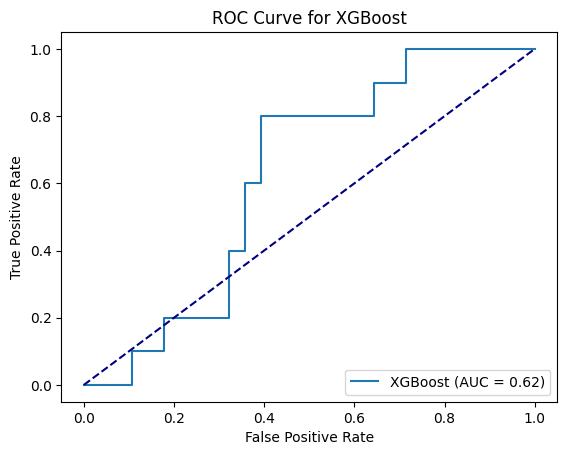

ROC AUC Score: 0.62
Accuracy: 0.66
Confusion Matrix:
[[23  5]
 [ 8  2]]


In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Load the data
data = pd.read_excel('/content/drive/MyDrive/fall 24/cdss discovery - ucsf covid/Key data files/delirium cohort demographics.xlsx', nrows=129)

# Step 2: Data Preprocessing
# Handle missing values
for column in data.select_dtypes(include=['float64', 'int64']).columns:
    data[column] = data[column].fillna(data[column].mean())

# Remove rows with 'Unknown' values in specific columns
data = data.loc[(data['Race'] != 'Unknown') & (data['Hispanic ethnicity'] != 'Unknown') & (data['Dementia'] != 'Unknown')]

# Step 3: One-Hot Encode Categorical Variables
def ohe_col(data, column):
    ohenc = OneHotEncoder()
    ohenc.fit(data[[column]])
    coldata = ohenc.transform(data[[column]]).toarray()
    coldf = pd.DataFrame(data=coldata, columns=ohenc.get_feature_names_out(), index=data.index)
    return data.join(coldf)

data = ohe_col(data, "Race")
data = ohe_col(data, "Sex at Birth")
data = ohe_col(data, "Dementia")

# Step 4: Train-Test Split
features = ['Age at Admission', 'SOFA', 'WHO Scale'] + list(data.filter(regex='^Race_').columns) + list(data.filter(regex='^Sex at Birth_').columns) + list(data.filter(regex='^Dementia_').columns)
X = data[features]
y = data['Delirium at any time during hospitalization']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize Numerical Features
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

# Step 5: Train XGBoost Model
xgb_model = XGBClassifier(random_state=42, n_estimators=100, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

# Step 6: Make Predictions and Evaluate Model
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]
y_pred = xgb_model.predict(X_test)

# Calculate AUC-ROC score
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Step 7: Plot the ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, label=f'XGBoost (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')  # Reference line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for XGBoost')
plt.legend(loc='lower right')
plt.show()

# Step 8: Output Additional Metrics
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f'ROC AUC Score: {roc_auc:.2f}')
print(f'Accuracy: {accuracy:.2f}')
print('Confusion Matrix:')
print(conf_matrix)

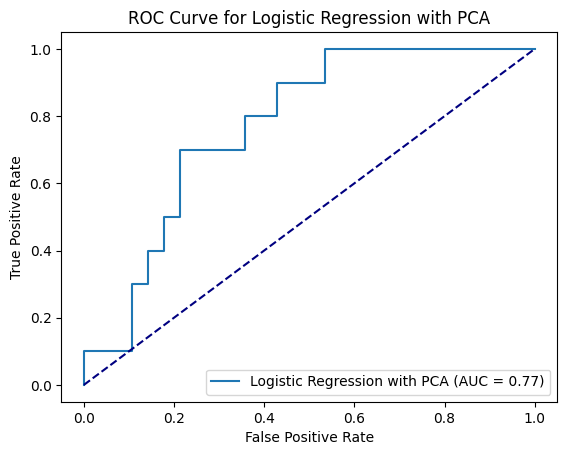

ROC AUC Score: 0.77
Accuracy: 0.68
Confusion Matrix:
[[25  3]
 [ 9  1]]


In [ ]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Load the data
data = pd.read_excel('/content/drive/MyDrive/fall 24/cdss discovery - ucsf covid/Key data files/delirium cohort demographics.xlsx', nrows=129)

# Step 2: Data Preprocessing
# Handle missing values
for column in data.select_dtypes(include=['float64', 'int64']).columns:
    data[column] = data[column].fillna(data[column].mean())

# Remove rows with 'Unknown' values in specific columns
data = data.loc[(data['Race'] != 'Unknown') & (data['Hispanic ethnicity'] != 'Unknown') & (data['Dementia'] != 'Unknown')]

# Step 3: One-Hot Encode Categorical Variables
def ohe_col(data, column):
    ohenc = OneHotEncoder()
    ohenc.fit(data[[column]])
    coldata = ohenc.transform(data[[column]]).toarray()
    coldf = pd.DataFrame(data=coldata, columns=ohenc.get_feature_names_out(), index=data.index)
    return data.join(coldf)

data = ohe_col(data, "Race")
data = ohe_col(data, "Sex at Birth")
data = ohe_col(data, "Dementia")

# Step 4: Train-Test Split
features = ['Age at Admission', 'SOFA', 'WHO Scale'] + list(data.filter(regex='^Race_').columns) + list(data.filter(regex='^Sex at Birth_').columns) + list(data.filter(regex='^Dementia_').columns)
X = data[features]
y = data['Delirium at any time during hospitalization']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize Numerical Features
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

# Step 5: Apply PCA
pca = PCA(n_components=10, random_state=42)  # Adjust the number of components based on explained variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Step 6: Train Logistic Regression Model on PCA-transformed data
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train_pca, y_train)

# Step 7: Make Predictions and Evaluate Model
y_pred_proba = lr_model.predict_proba(X_test_pca)[:, 1]
y_pred = lr_model.predict(X_test_pca)

# Calculate AUC-ROC score
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Step 8: Plot the ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, label=f'Logistic Regression with PCA (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')  # Reference line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression with PCA')
plt.legend(loc='lower right')
plt.show()

# Step 9: Output Additional Metrics
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f'ROC AUC Score: {roc_auc:.2f}')
print(f'Accuracy: {accuracy:.2f}')
print('Confusion Matrix:')
print(conf_matrix)